# **Import**

---



In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

#from keras.utils import np_utils

import warnings
warnings.filterwarnings(action='ignore')

# **1. NLP Preprocessing**

---



## **1-1 Data 불러오기**

---



In [2]:
# train data

train = pd.read_csv('train.csv')
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [3]:
# test data

test = pd.read_csv('test_x.csv')
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [4]:
# sample_submission data

sam_sub = pd.read_csv('sample_submission.csv')
sam_sub

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


## **1-2 stopwords(불용어) 제거**

---



In [5]:
# 부호 제거해주는 함수

def alpha_num(text):
  return re.sub('[^A-Za-z0-9\\s]', '', text)

**re.sub()** : 문자,숫자 제외한 기호 -> ' ' 로 대체 (제거)

**[^문자]** : ^ 기호 뒤에 붙은 문자들을 제외한 모든 문자

**\\\s** : 공백

In [6]:
# 불용어 제거해주는 함수

def remove_stopwords(text):
  final_text = []
  for word in text.split():
    if word.strip().lower() not in stopwords:
      final_text.append(word.strip())
  return ' '.join(final_text)

**strip()** : 문자열 및 공백 제거

**join()** : 문자열 이어붙이기

In [7]:
# 불용어

stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as",
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could",
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has",
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself",
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself",
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours",
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that",
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll",
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll",
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom",
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [8]:
# 소문자로 바꾼 후 전처리

train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [9]:
train

,index,text,author
0,0,almost choking much much wanted say strange ex...,3
1,1,sister asked suppose,2
2,2,engaged one day walked perusing janes last let...,1
3,3,captain porch keeping carefully way treacherou...,4
4,4,mercy gentlemen odin flung hands dont write an...,3
...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope come,2
54875,54875,told plan captain us settled details accomplis...,4
54876,54876,sincere wellwisher friend sister lucy odin,1
54877,54877,wanted lend money,3


## **1-3 Data 시각화**

---



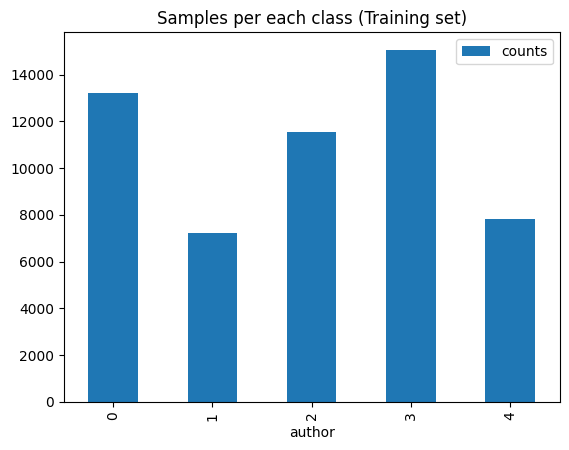

In [10]:
# 작가별 분포도 확인

train.groupby('author')['text'].count().plot(kind='bar')
plt.title('Samples per each class (Training set)')
plt.xlabel('author')
plt.legend(['counts'])
plt.show()

**groupby()** : 특정 열을 그룹으로 묶어 분석

**count()** : 특정 그룹별 개수

In [11]:
# 문장 길이 분포도 확인

train['text_len'] = train['text'].apply(lambda words: len(words.split()))

def plot_textLengths(dataframe):
  mean_seq_len = np.round(dataframe['text_len'].mean()).astype(int)
  sns.distplot(dataframe['text_len'], hist=True, kde=True, label='Text lengths')
  plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
  plt.title('Text lengths')
  plt.legend()
  plt.show()
  print(f"Max length text: {train['text_len'].max()}개 단어, Min length text: {train['text_len'].min()}개 단어")

**apply(lambda x:)** : apply 함수가 lambda 함수를 부르고 lambda가 수행하는 것을 적용

**lambda 함수** : def 함수 간단한 버전 (일회성으로 사용 편리, 코드 간결)

**[distplot 함수]** hist: 막대 그래프, kde: 커널 밀도 (선 표시)

**axvline()** : 그래프 특정 위치에 수직선 표시

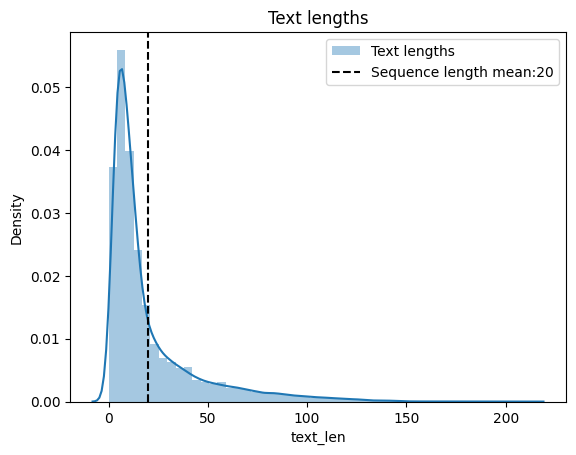

Max length text: 211개 단어, Min length text: 0개 단어


In [12]:
plot_textLengths(train)

In [13]:
train

,index,text,author,text_len
0,0,almost choking much much wanted say strange ex...,3,20
1,1,sister asked suppose,2,3
2,2,engaged one day walked perusing janes last let...,1,30
3,3,captain porch keeping carefully way treacherou...,4,31
4,4,mercy gentlemen odin flung hands dont write an...,3,20
...,...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope come,2,8
54875,54875,told plan captain us settled details accomplis...,4,7
54876,54876,sincere wellwisher friend sister lucy odin,1,6
54877,54877,wanted lend money,3,3


# **2. Vectorization**

---



## **2-1 Tokenization**

---



In [14]:
# data array로 만들기

x_train = np.array([x for x in train['text']])
x_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(54879,)
(19617,)
(54879,)


In [15]:
print(x_train)
print(x_test)
print(y_train)

['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity'
 'sister asked suppose'
 'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said'
 ... 'sincere wellwisher friend sister lucy odin' 'wanted lend money'
 'certainly not occurred said yes like']
['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment'
 'no replied sudden consciousness not find cannot ignorant goodness owe alli feel iti express couldbut well know no orator'
 'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner heard mr odin darted much ag

In [16]:
vocab_size = 2000

# data에 있는 모든 단어개수 세서 빈도수로 정렬 후 num_words만큼만 숫자로 반환, 나머지는 0으로 반환
tokenizer = Tokenizer(num_words = vocab_size)

# Tokenizer에 data 실제로 입력
tokenizer.fit_on_texts(x_train)

# 문장 내 모든 단어를 sequence 번호로 변환
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

print(len(sequences_train), len(sequences_test))

54879 19617


## **2-2 Padding & One-Hot-Encoding**

---



In [17]:
# padding

max_length = 211 # max length text: 211개 단어

X_train = pad_sequences(sequences_train, padding='post', maxlen=max_length)
X_test = pad_sequences(sequences_test, padding='post', maxlen=max_length)

print(X_train.shape, X_test.shape)

(54879, 211) (19617, 211)


**padding='post'** : 뒤(post)로 padding

('pre' : 앞에 padding)

In [18]:
# One-Hot Encoding

Y_train = to_categorical(y_train)

print(Y_train, Y_train.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]] (54879, 5)


# **3. Modeling**

## **3-1 양방향 LSTM**

In [19]:
# vocab_size = 2000
# max_length = 150
embedding_dim = 200

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(5, activation='softmax')) # 결과값 0~4이므로 Dense(5)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 211, 200)          400000    
                                                                 
 bidirectional (Bidirection  (None, 211, 128)          135680    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 211, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                        

In [22]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=100, validation_split=0.2)

Epoch 1/50
440/440 [==============================] - 89s 165ms/step - loss: 1.1168 - accuracy: 0.5464 - val_loss: 0.9190 - val_accuracy: 0.6465
Epoch 2/50
440/440 [==============================] - 35s 81ms/step - loss: 0.8578 - accuracy: 0.6668 - val_loss: 0.8890 - val_accuracy: 0.6590
Epoch 3/50
440/440 [==============================] - 31s 70ms/step - loss: 0.7943 - accuracy: 0.6929 - val_loss: 0.8832 - val_accuracy: 0.6638
Epoch 4/50
440/440 [==============================] - 28s 64ms/step - loss: 0.7548 - accuracy: 0.7108 - val_loss: 0.8841 - val_accuracy: 0.6643
Epoch 5/50
440/440 [==============================] - 29s 67ms/step - loss: 0.7235 - accuracy: 0.7221 - val_loss: 0.9007 - val_accuracy: 0.6609
Epoch 6/50
440/440 [==============================] - 27s 61ms/step - loss: 0.6968 - accuracy: 0.7312 - val_loss: 0.9307 - val_accuracy: 0.6572
Epoch 7/50
440/440 [==============================] - 27s 62ms/step - loss: 0.6678 - accuracy: 0.7428 - val_loss: 0.9515 - val_accuracy

<function matplotlib.pyplot.show(close=None, block=None)>

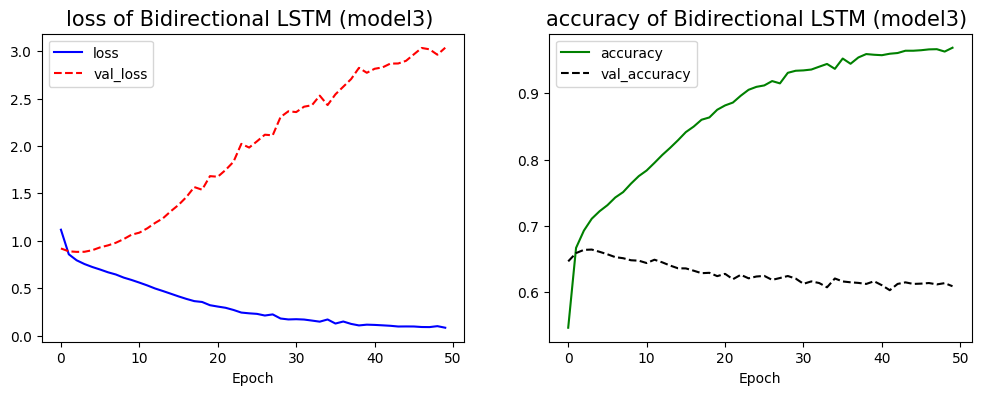

In [23]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

loss 값은 줄어들지만, val_loss 값은 점점 상승

val_accuracy 결과 제대로 안나옴

모델 성능 평가의 일반화 위해 교차 검증 필요

## **3-2 교차 검증 적용**

계층 교차 검증(StratifiedKFold) 적용 후 모델 일반화

In [24]:
# 계층 교차 검증
n_fold = 5
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(X_train, y_train), 1):
    print(f'training model for CV #{i}')

    model.fit(X_train[i_trn], to_categorical(y_train[i_trn]), validation_data=(X_train[i_val], to_categorical(y_train[i_val])), epochs=10, batch_size=512)

training model for CV #1
Epoch 1/10
86/86 [==============================] - 26s 298ms/step - loss: 0.5168 - accuracy: 0.8965 - val_loss: 0.4125 - val_accuracy: 0.9023
Epoch 2/10
86/86 [==============================] - 18s 212ms/step - loss: 0.3204 - accuracy: 0.9203 - val_loss: 0.3921 - val_accuracy: 0.9061
Epoch 3/10
86/86 [==============================] - 16s 185ms/step - loss: 0.2683 - accuracy: 0.9322 - val_loss: 0.3919 - val_accuracy: 0.9055
Epoch 4/10
86/86 [==============================] - 15s 176ms/step - loss: 0.2361 - accuracy: 0.9391 - val_loss: 0.3961 - val_accuracy: 0.9036
Epoch 5/10
86/86 [==============================] - 15s 167ms/step - loss: 0.2103 - accuracy: 0.9442 - val_loss: 0.4060 - val_accuracy: 0.9008
Epoch 6/10
86/86 [==============================] - 14s 161ms/step - loss: 0.1889 - accuracy: 0.9497 - val_loss: 0.4140 - val_accuracy: 0.8997
Epoch 7/10
86/86 [==============================] - 14s 162ms/step - loss: 0.1711 - accuracy: 0.9540 - val_loss: 0.42

기존보다 개선된 결과값 보여줌

하지만 val_loss, val_accuracy 결과값 모면 조기종료 옵션 추가 필요

In [25]:
# 계층 교차 검증
n_fold = 5
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
Y_test = np.zeros((X_test.shape[0], 5))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(X_train, y_train), 1):
    print(f'training model for CV #{i}')

    model.fit(X_train[i_trn], to_categorical(y_train[i_trn]), validation_data=(X_train[i_val], to_categorical(y_train[i_val])), epochs=10, batch_size=512, callbacks=[es])     # 조기 종료 옵션

    Y_test += model.predict(X_test) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
86/86 [==============================] - 13s 153ms/step - loss: 0.0741 - accuracy: 0.9732 - val_loss: 0.0670 - val_accuracy: 0.9753
Epoch 2/10
86/86 [==============================] - 13s 151ms/step - loss: 0.0754 - accuracy: 0.9728 - val_loss: 0.0764 - val_accuracy: 0.9718
Epoch 3/10
86/86 [==============================] - 13s 154ms/step - loss: 0.0732 - accuracy: 0.9733 - val_loss: 0.1138 - val_accuracy: 0.9595
Epoch 4/10
86/86 [==============================] - 13s 152ms/step - loss: 0.0635 - accuracy: 0.9766 - val_loss: 0.1136 - val_accuracy: 0.9606
Epoch 4: early stopping
614/614 [==============================] - 13s 19ms/step
training model for CV #2
Epoch 1/10
86/86 [==============================] - 13s 151ms/step - loss: 0.0672 - accuracy: 0.9758 - val_loss: 0.0636 - val_accuracy: 0.9767
Epoch 2/10
86/86 [==============================] - 14s 158ms/step - loss: 0.0545 - accuracy: 0.9794 - val_loss: 0.0680 - val_accuracy: 0.9741
Epoch 3/10


## **3-3 Test Data 적용**

In [26]:
# 테스트 데이터의 예측값 확인
Y_test

array([[2.55918977e-06, 9.99995157e-01, 7.98941798e-07, 6.48667282e-07,
        8.45106733e-07],
       [9.95863512e-01, 3.50244549e-03, 3.54392510e-04, 4.82502969e-05,
        2.31413641e-04],
       [7.41868712e-01, 3.43685511e-03, 7.64333445e-05, 3.05213539e-05,
        2.54587511e-01],
       ...,
       [2.54140859e-06, 9.99963090e-01, 2.50271979e-06, 1.87069683e-05,
        1.31598861e-05],
       [4.88130109e-06, 9.99983698e-01, 3.19439550e-06, 7.03051423e-06,
        1.17311845e-06],
       [9.99801129e-01, 5.86584653e-05, 7.23446529e-06, 7.02402838e-08,
        1.32909182e-04]])

In [27]:
# sample_submission 대입
sam_sub[['0','1', '2', '3', '4']] = Y_test
sam_sub

,index,0,1,2,3,4
0,0,2.559190e-06,9.999952e-01,7.989418e-07,6.486673e-07,8.451067e-07
1,1,9.958635e-01,3.502445e-03,3.543925e-04,4.825030e-05,2.314136e-04
2,2,7.418687e-01,3.436855e-03,7.643334e-05,3.052135e-05,2.545875e-01
3,3,2.285090e-04,1.488890e-05,9.997434e-01,1.330858e-06,1.190805e-05
4,4,2.119546e-04,2.629577e-05,1.497373e-06,2.326095e-03,9.974342e-01
...,...,...,...,...,...,...
19612,19612,4.056710e-06,9.999930e-01,5.135767e-07,4.959546e-07,1.939657e-06
19613,19613,7.475684e-07,7.090498e-07,5.530622e-08,1.004562e-05,9.999884e-01
19614,19614,2.541409e-06,9.999631e-01,2.502720e-06,1.870697e-05,1.315989e-05
19615,19615,4.881301e-06,9.999837e-01,3.194396e-06,7.030514e-06,1.173118e-06


In [29]:
sam_sub.to_csv('submission.csv', index=False, encoding='utf-8')